In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
# Global libs 
import logging 
from datetime import datetime 
from collections import defaultdict

# ML/DS libs
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.utils import resample
from sklearn.metrics import f1_score, log_loss, precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Local libs 
import reader
import preprocessing
import features

In [2]:
sessions = ['PRE','TEST01','TEST02','TEST03','TEST04','TEST05','TEST06','TEST07','TEST08','POST']
participants = range(1,74,1) # P001-P073

target_window_length = 10
target_stride = 10 # Must upsample to match this period! Otherwise we're cheating
target_feature = 'annotation'
target_key = 'R1'
target_threshold = 3 # 0 if < threshold, 1 if >= threshold

labels = ['negative','positive']

data_features = [
    'IS09_10sec', 
    'IS10_10sec',
    'E4_10sec'
]

data_functions = [
    lambda f1d: features.format_extracted_features(
        f1d, 
        target_keys=None,
        repair_fns=None,
        shift_fn=lambda fh1: preprocessing.shift_dataframe(fh1, 1, True), 
        sampling_fn=None
    ),
    lambda f3d: features.format_extracted_features(
        f3d, 
        target_keys=None,
        repair_fns=None,
        shift_fn=lambda fh3: preprocessing.shift_dataframe(fh3, 1, True), 
        sampling_fn=None
    ),
    lambda f2d: features.format_extracted_features(
        f2d,
        target_keys=['SCL', 'SCR_amp', 'SCR_freq'],
        repair_fns={'SCR_amp':lambda f1r: preprocessing.repair_series(f1r, 'zero')},
        shift_fn=lambda fh2: preprocessing.shift_dataframe(fh2, 1, True),
        sampling_fn=None
        
    )
]


In [3]:
# Usage:
# data[pid][(feature, session)] = data
# data_missing[pt][feature] = [sessions]
data, data_missing = reader.get_pts_data('data/extracted_data/', data_features, participants, sessions, 'excel')
target, target_missing = reader.get_pts_data('data/extracted_data/', [target_feature], participants, sessions, 'excel')

In [4]:
# Take set difference of all pts and missing pts to get valid pts with no missing data or sessions
all_pts_set = set(participants)
missing_pts_data = set(data_missing.keys())
missing_pts_target = set(target_missing.keys())
valid_pts = all_pts_set - missing_pts_data - missing_pts_target

In [5]:
pt_dfs = {}
for pt in participants:
    missing_pt_sessions = set()
    missing_pt_sessions.update(target_missing[pt][target_feature])
    for data_feature in data_features:
        missing_pt_sessions.update(data_missing[pt][data_feature])
    valid_pt_sessions = [s for s in sessions if s not in missing_pt_sessions]
    
    if len(valid_pt_sessions) == 0: continue
    pt_df_list = []

    for session in valid_pt_sessions:
        target_df = target[pt][(target_feature,session)]
        session_dfs = []
        df = features.format_annotation(
            target_df,
            window_size=target_window_length,
            stride=target_stride,
            window_fn=lambda x: np.mean(x,axis=0),
            threshold=target_threshold,
            time_key='Time (s)',
            target_keys=[target_key]
        )
        session_dfs.append(df)

        for data_feature, data_function in zip(data_features, data_functions):
            data_df = data[pt][(data_feature, session)]
            data_df = data_function(data_df)
            session_dfs.append(data_df)

        session_df = preprocessing.combine_dataframes(session_dfs)
        
        pt_df_list.append(session_df)
    
    pt_dfs[pt] = pd.concat(pt_df_list, axis=0, ignore_index=True) # Combine participants sessions along sample axis

In [86]:
print('Running...')

pts_with_data = list(pt_dfs.keys())

preserve_keys = [
    'SCL',
    'SCR_amp',
    'SCR_freq',
    'pcm_zcr_sma_amean',
    'voiceProb_sma_amean',
    'F0_sma_amean',
    'pcm_loudness_sma_amean',
    'jitterLocal_sma_amean',
    'shimmerLocal_sma_amean'
]

print('Filtering by correlations...')

df_all = pd.concat(pt_dfs.values(), axis=0, ignore_index=True)
df_all, dropped_keys, kept_keys = features.drop_target_correlations(df_all, target_key,-0.1, 0.1, 0.5, preserve_keys=preserve_keys)    
    
print('\nDropped features:')
for d in dropped_keys: print(d)
print('\nKept features:')
for k in kept_keys: print(k)
print('\nUsed keys:')
for c in df_all.columns: print(c)
print('\n')

Running...
Filtering by correlations...

Dropped features:
pcm_RMSenergy_sma_amean
pcm_fftMag_mfcc_sma[1]_amean
pcm_fftMag_mfcc_sma[2]_amean
pcm_fftMag_mfcc_sma[4]_amean
pcm_fftMag_mfcc_sma[5]_amean
pcm_fftMag_mfcc_sma[6]_amean
pcm_fftMag_mfcc_sma[7]_amean
pcm_fftMag_mfcc_sma[8]_amean
pcm_fftMag_mfcc_sma[9]_amean
pcm_fftMag_mfcc_sma[10]_amean
pcm_fftMag_mfcc_sma[11]_amean
pcm_fftMag_mfcc_sma[12]_amean
pcm_RMSenergy_sma_de_amean
pcm_fftMag_mfcc_sma_de[1]_amean
pcm_fftMag_mfcc_sma_de[2]_amean
pcm_fftMag_mfcc_sma_de[3]_amean
pcm_fftMag_mfcc_sma_de[4]_amean
pcm_fftMag_mfcc_sma_de[5]_amean
pcm_fftMag_mfcc_sma_de[6]_amean
pcm_fftMag_mfcc_sma_de[7]_amean
pcm_fftMag_mfcc_sma_de[8]_amean
pcm_fftMag_mfcc_sma_de[9]_amean
pcm_fftMag_mfcc_sma_de[10]_amean
pcm_fftMag_mfcc_sma_de[11]_amean
pcm_fftMag_mfcc_sma_de[12]_amean
pcm_zcr_sma_de_amean
voiceProb_sma_de_amean
F0_sma_de_amean
mfcc_sma[1]_amean
mfcc_sma[2]_amean
mfcc_sma[3]_amean
mfcc_sma[4]_amean
mfcc_sma[5]_amean
mfcc_sma[6]_amean
mfcc_sma[7]_a

Running...
Filtering by correlations...
Total samples extracted: 7363
Original Distribution ==> False: 6404, True: 852


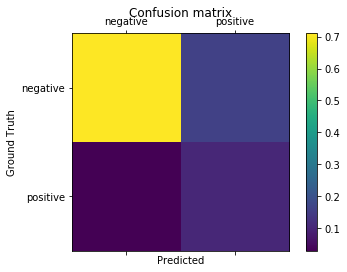

Original Distribution ==> False: 6478, True: 862


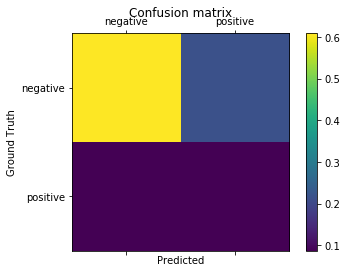

Original Distribution ==> False: 6222, True: 847


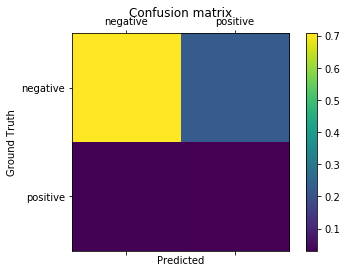

Original Distribution ==> False: 6314, True: 851


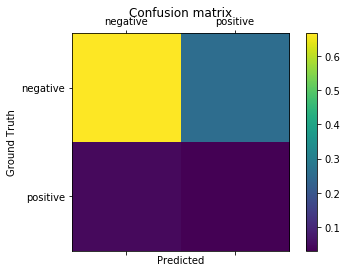

Original Distribution ==> False: 6470, True: 865


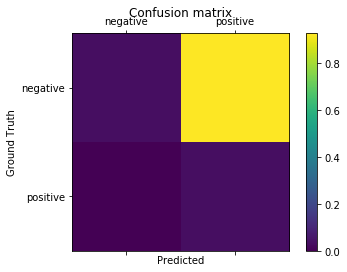

Original Distribution ==> False: 6295, True: 859


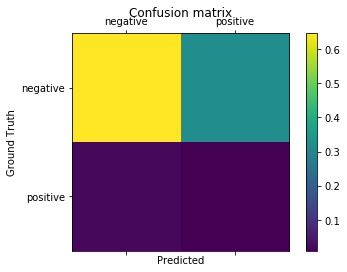

Original Distribution ==> False: 6485, True: 839


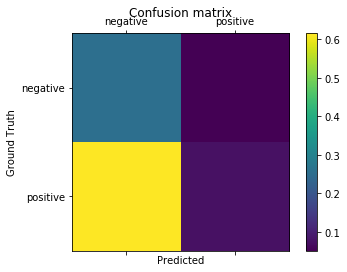

Original Distribution ==> False: 6472, True: 866
Original Distribution ==> False: 6409, True: 846


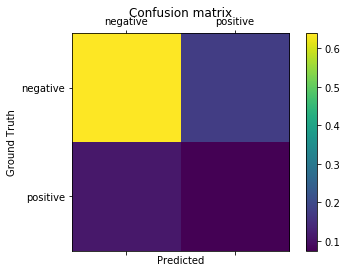

Original Distribution ==> False: 6489, True: 849


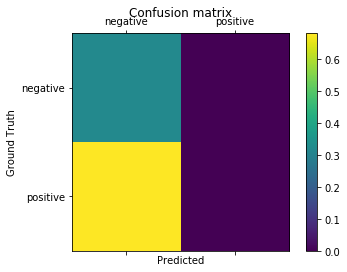

Original Distribution ==> False: 6312, True: 790


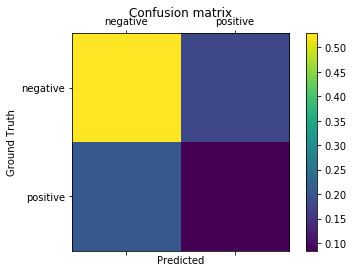

Original Distribution ==> False: 6496, True: 855


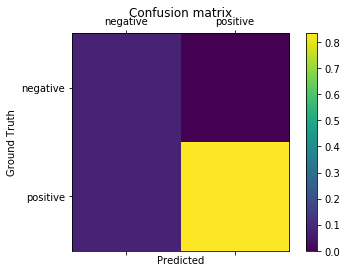

Original Distribution ==> False: 6469, True: 865


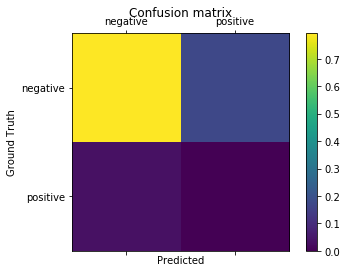

Original Distribution ==> False: 6399, True: 796


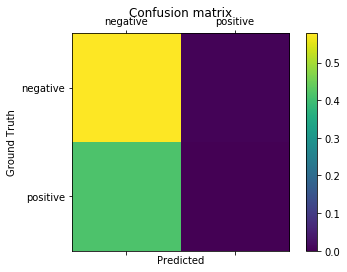

Original Distribution ==> False: 6372, True: 856


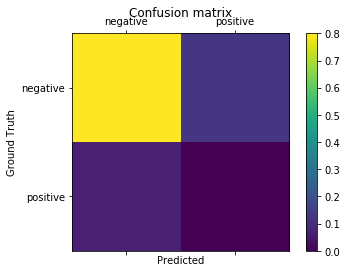

Original Distribution ==> False: 6241, True: 849


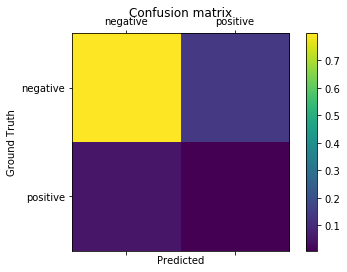

Original Distribution ==> False: 6470, True: 864


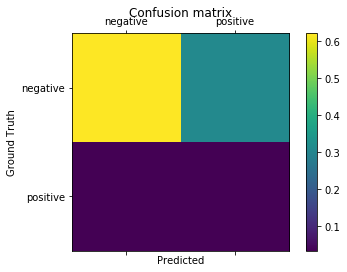

Original Distribution ==> False: 6380, True: 859


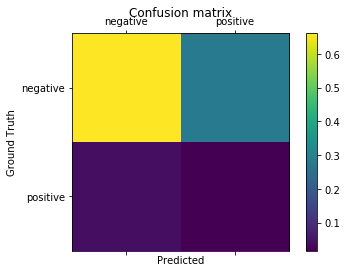

Original Distribution ==> False: 6470, True: 866
Original Distribution ==> False: 6297, True: 787


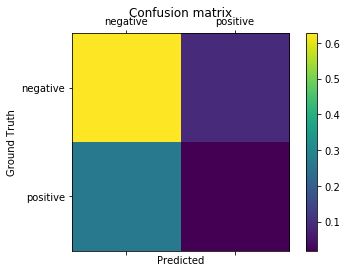

Original Distribution ==> False: 6179, True: 866
Original Distribution ==> False: 6249, True: 866
Original Distribution ==> False: 6382, True: 863


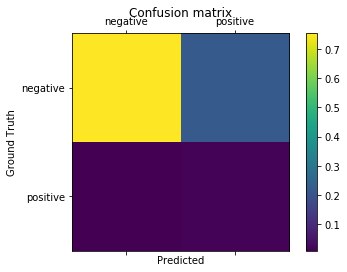

Original Distribution ==> False: 6293, True: 860


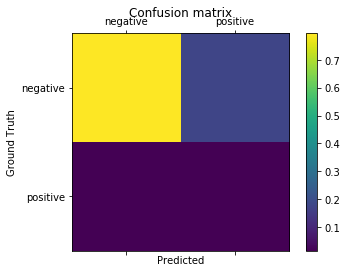

Original Distribution ==> False: 6493, True: 856


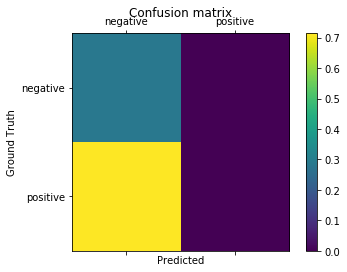

Original Distribution ==> False: 6292, True: 848


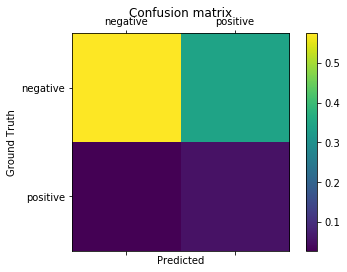

Original Distribution ==> False: 6283, True: 857


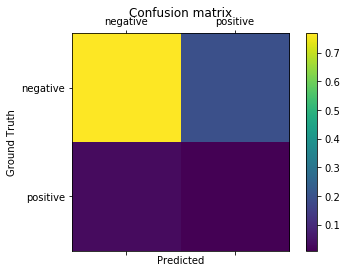

Original Distribution ==> False: 6367, True: 829


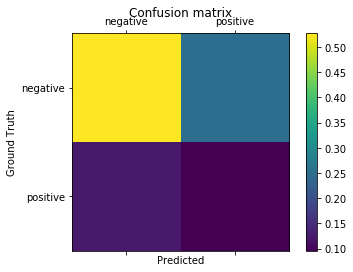

Original Distribution ==> False: 6343, True: 837


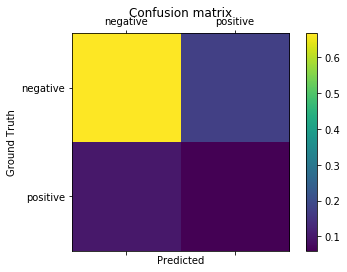

Original Distribution ==> False: 6390, True: 863


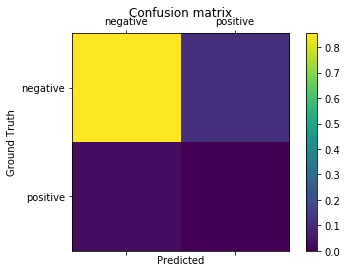

Original Distribution ==> False: 6324, True: 866
Original Distribution ==> False: 6283, True: 820


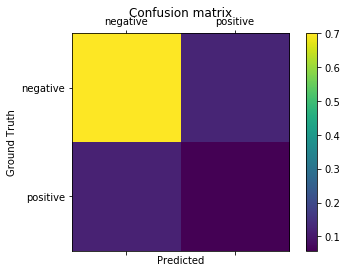

Original Distribution ==> False: 6355, True: 866
Original Distribution ==> False: 6370, True: 866
Original Distribution ==> False: 6314, True: 864


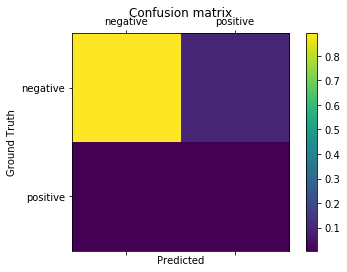

Original Distribution ==> False: 6302, True: 830


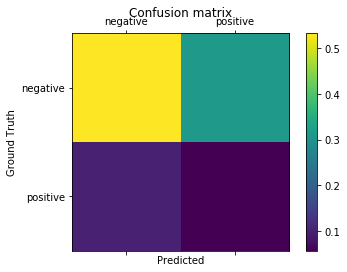

Original Distribution ==> False: 6469, True: 866
Original Distribution ==> False: 6357, True: 824


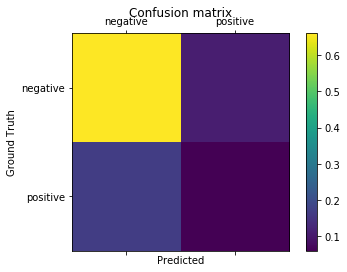

Original Distribution ==> False: 6468, True: 866
Original Distribution ==> False: 6482, True: 863


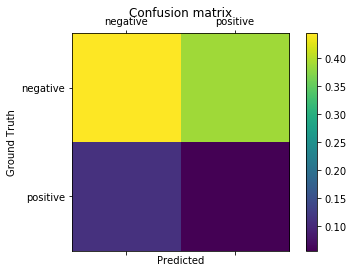

Original Distribution ==> False: 6373, True: 837


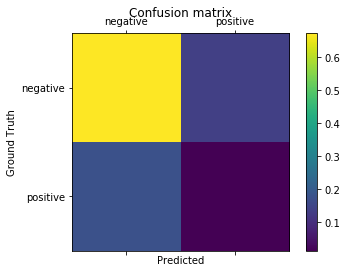

Original Distribution ==> False: 6320, True: 829


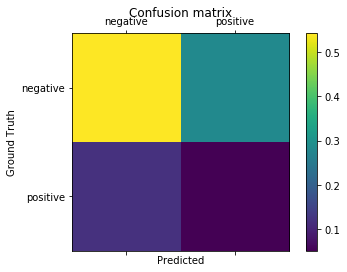

Original Distribution ==> False: 6373, True: 862


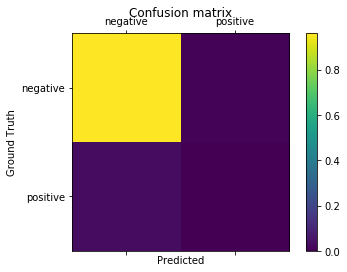

Original Distribution ==> False: 6369, True: 771


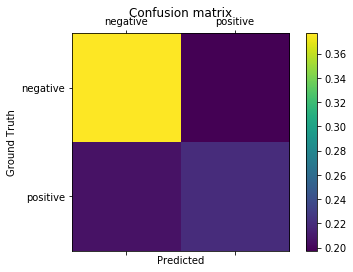

Original Distribution ==> False: 6468, True: 866
Original Distribution ==> False: 6467, True: 866
Original Distribution ==> False: 6239, True: 865


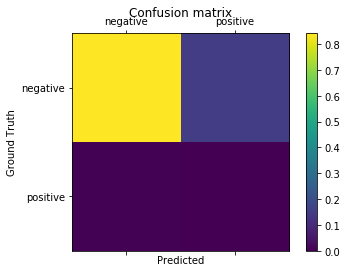

Original Distribution ==> False: 6316, True: 862


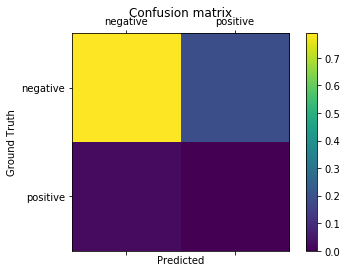

Original Distribution ==> False: 6371, True: 865


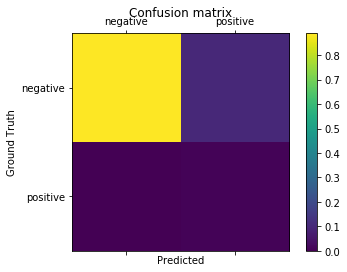

Original Distribution ==> False: 6476, True: 865


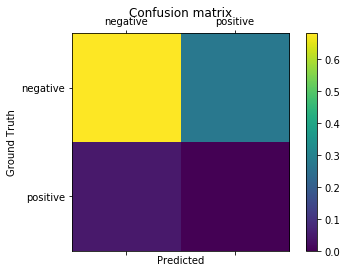

Original Distribution ==> False: 6288, True: 837


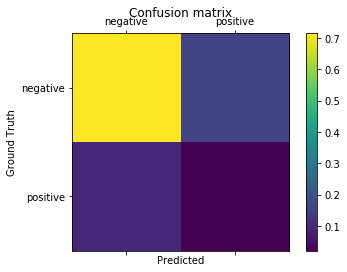

Original Distribution ==> False: 6474, True: 866
Original Distribution ==> False: 6371, True: 842


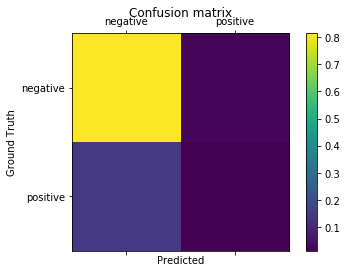


Average metrics for LOSO CV: 
Acc 0.68 | 
F1 0.17 | 
Log Loss 1.69
Precision 0.16 | 
Recall 0.31
True Positive Rate 0.31 | 
False Positive Rate 0.21


In [82]:
print('Running...')

pts_with_data = list(pt_dfs.keys())

preserve_keys = [
    'SCL',
    'SCR_amp',
    'SCR_freq',
    'pcm_zcr_sma_amean',
    'voiceProb_sma_amean',
    'F0_sma_amean',
    'pcm_loudness_sma_amean',
    'jitterLocal_sma_amean',
    'shimmerLocal_sma_amean'
]

print('Filtering by correlations...')

df_all = pd.concat(pt_dfs.values(), axis=0, ignore_index=True)
df_all, dropped_keys, kept_keys = features.drop_target_correlations(df_all, target_key,-0.25, 0.25, 0.01, preserve_keys=preserve_keys)    
    
print('\nDropped features:')
for d in dropped_keys: print(d)
print('\nKept features:')
for k in kept_keys: print(k)
print('\nUsed keys:')
for c in df_all.columns: print(c)
print('\n')

print('Total samples extracted: {0}'.format(len(df_all.index)))

fold_metrics = []
for pt_leave_out in pts_with_data:
    test_data = pt_dfs[pt_leave_out] # List of participant sessions dataframes
    train_data = []
    for pt in pts_with_data:
        if pt != pt_leave_out:
            train_data.append(pt_dfs[pt])

    train_data = pd.concat(train_data, axis=0, ignore_index=True) # Combine ALL participants along sample axis

    # Resample to minority class, truncate, and shuffle

    false_class = train_data[train_data[target_key] == 0]
    true_class = train_data[train_data[target_key] == 1]

    n_false = len(false_class.index)
    n_true = len(true_class.index)

    new_count = min(n_false, n_true)
    # Oversample
    #new_count = (n_false + n_true) // 2

    false_class_sampled = resample(false_class, replace=True, n_samples=new_count, random_state=123)
    true_class_sampled = resample(true_class, replace=True, n_samples=new_count, random_state=123)

    print('Original Distribution ==> False: {0}, True: {1}'.format(n_false, n_true))

    train_data = pd.concat([false_class_sampled, true_class_sampled], axis=0)
    train_data = train_data.sample(frac=1).reset_index(drop=True)


    train_data = train_data.drop(dropped_keys, axis=1)
    test_data = test_data.drop(dropped_keys, axis=1)

    y_train = train_data[target_key] # Get only annotation key
    X_train = train_data.drop(target_key, axis=1) # Get all but annotation key

    y_test = test_data[target_key]
    X_test = test_data.drop(target_key, axis=1)

    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
    model = BaggingClassifier(n_estimators=10)
    #model = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=500, class_weight='balanced_subsample')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)


    tp = 0
    fp = 0
    tn = 0
    fn = 0
    y_test = y_test.to_numpy()
    for i in range(y_pred.shape[0]):
        if y_pred[i]==y_test[i]==1: tp += 1
        if y_pred[i]==1 and y_test[i] != y_pred[i]: fp += 1
        if y_pred[i]==y_test[i]==0: tn += 1
        if y_pred[i]==0 and y_test[i] != y_pred[i]: fn += 1

    if (tp+fn) == 0: continue # Skip, whatever
    if (fp+tn) == 0: continue
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, labels=[0,1])
    lg_loss = log_loss(y_test, y_probs, labels=[0,1])
    precision = precision_score(y_test, y_pred, labels=[0,1], zero_division=0)
    recall = recall_score(y_test, y_pred, labels=[0,1], zero_division=0)

    cm = confusion_matrix(y_test, y_pred, normalize='all',labels=[0,1])


    fold_metrics.append((acc, f1, lg_loss, precision, recall, tpr, fpr))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.show()

#         print('Fold completed for subject {0} with Acc {1:.2f} | Prec {2:.2f} | Recall {3:.2f}'.format(pt_leave_out, acc, precision, recall))

avg_metrics = np.mean(fold_metrics,axis=0)
print('\nAverage metrics for LOSO CV: \nAcc {0:.2f} | \nF1 {1:.2f} | \nLog Loss {2:.2f}'.format(avg_metrics[0], avg_metrics[1], avg_metrics[2]))
print('Precision {0:.2f} | \nRecall {1:.2f}'.format(avg_metrics[3],avg_metrics[4]))
print('True Positive Rate {0:.2f} | \nFalse Positive Rate {1:.2f}'.format(avg_metrics[5],avg_metrics[6]))


In [80]:
print('Running...')

pts_with_data = list(pt_dfs.keys())

preserve_keys = [
    'SCL',
    'SCR_amp',
    'SCR_freq',
    'pcm_zcr_sma_amean',
    'voiceProb_sma_amean',
    'F0_sma_amean',
    'pcm_loudness_sma_amean',
    'jitterLocal_sma_amean',
    'shimmerLocal_sma_amean'
]

print('Filtering by correlations...')

df_all = pd.concat(pt_dfs.values(), axis=0, ignore_index=True)
df_all, dropped_keys, kept_keys = features.drop_target_correlations(df_all, target_key,-0.05, 0.05, 0.05, preserve_keys=preserve_keys)    
    
print('\nDropped features:')
for d in dropped_keys: print(d)
print('\nKept features:')
for k in kept_keys: print(k)
print('\nUsed keys:')
for c in df_all.columns: print(c)
print('\n')

print(len(df_all.columns))

print('Total samples extracted: {0}'.format(len(df_all.index)))

prob_thresholds = np.arange(0.0, 1.025, 0.025)

metrics = defaultdict(list)

for pt_leave_out in pts_with_data:
    test_data = pt_dfs[pt_leave_out] # List of participant sessions dataframes
    train_data = []
    for pt in pts_with_data:
        if pt != pt_leave_out:
            train_data.append(pt_dfs[pt])

    train_data = pd.concat(train_data, axis=0, ignore_index=True) # Combine ALL participants along sample axis

    # Resample to minority class, truncate, and shuffle

    false_class = train_data[train_data[target_key] == 0]
    true_class = train_data[train_data[target_key] == 1]

    n_false = len(false_class.index)
    n_true = len(true_class.index)

    # Oversample
    new_count = min(n_false, n_true)

    false_class_sampled = resample(false_class, replace=True, n_samples=new_count, random_state=123)
    true_class_sampled = resample(true_class, replace=True, n_samples=new_count, random_state=123)

    #print('Original Distribution ==> False: {0}, True: {1}'.format(n_false, n_true))

    train_data = pd.concat([false_class_sampled, true_class_sampled], axis=0)
    train_data = train_data.sample(frac=1).reset_index(drop=True)


    train_data = train_data.drop(dropped_keys, axis=1)
    test_data = test_data.drop(dropped_keys, axis=1)

    y_train = train_data[target_key] # Get only annotation key
    X_train = train_data.drop(target_key, axis=1) # Get all but annotation key

    y_test = test_data[target_key]
    X_test = test_data.drop(target_key, axis=1)


    test_true_class = test_data[test_data[target_key] == 1]
    n_test_true = len(test_true_class.index)
    if n_test_true == 0: # Just skip if there are no positive samples
        continue 

    model = RandomForestClassifier(n_estimators=30, max_depth=30, random_state=500, class_weight={0:1, 1:1})
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)

    precs = []
    recalls = []
    tps = []
    fps = []
    y_test = y_test.to_numpy()
    for prob_threshold in prob_thresholds:

        y_pred = np.where(y_probs[:,1] >= prob_threshold, 1, 0) # Apply threshold instead for ROC 

        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(y_pred.shape[0]):
            if y_pred[i]==y_test[i]==1: tp += 1
            if y_pred[i]==1 and y_test[i] != y_pred[i]: fp += 1
            if y_pred[i]==y_test[i]==0: tn += 1
            if y_pred[i]==0 and y_test[i] != y_pred[i]: fn += 1

        try:
            tpr = tp/(tp+fn)
            fpr = fp/(fp+tn)
            precision = tp/(tp+fp)
            recall = tp/(tp+fn)
        except ZeroDivisionError:
            continue 

        precs.append(precision)
        recalls.append(recall)
        tps.append(tpr)
        fps.append(fpr)
        metrics[prob_threshold].append((precision, recall, tpr, fpr))

    print('Completed fold')



Running...
Filtering by correlations...

Dropped features:
pcm_fftMag_mfcc_sma[1]_amean
pcm_fftMag_mfcc_sma[2]_amean
pcm_fftMag_mfcc_sma[4]_amean
pcm_fftMag_mfcc_sma[5]_amean
pcm_fftMag_mfcc_sma[7]_amean
pcm_fftMag_mfcc_sma[9]_amean
pcm_fftMag_mfcc_sma[10]_amean
pcm_fftMag_mfcc_sma[12]_amean
pcm_RMSenergy_sma_de_amean
pcm_fftMag_mfcc_sma_de[1]_amean
pcm_fftMag_mfcc_sma_de[2]_amean
pcm_fftMag_mfcc_sma_de[3]_amean
pcm_fftMag_mfcc_sma_de[4]_amean
pcm_fftMag_mfcc_sma_de[5]_amean
pcm_fftMag_mfcc_sma_de[6]_amean
pcm_fftMag_mfcc_sma_de[7]_amean
pcm_fftMag_mfcc_sma_de[8]_amean
pcm_fftMag_mfcc_sma_de[9]_amean
pcm_fftMag_mfcc_sma_de[10]_amean
pcm_fftMag_mfcc_sma_de[11]_amean
pcm_fftMag_mfcc_sma_de[12]_amean
pcm_zcr_sma_de_amean
voiceProb_sma_de_amean
F0_sma_de_amean
mfcc_sma[1]_amean
mfcc_sma[2]_amean
mfcc_sma[4]_amean
mfcc_sma[5]_amean
mfcc_sma[7]_amean
mfcc_sma[9]_amean
mfcc_sma[10]_amean
mfcc_sma[12]_amean
mfcc_sma[13]_amean
lspFreq_sma[0]_amean
lspFreq_sma[2]_amean
lspFreq_sma[3]_amean
lspFr

KeyboardInterrupt: 

Metrics with threshold 0.00: Precision = 0.18 | Recall = 1.00 | TPR = 1.00 | FPR = 1.00
Metrics with threshold 0.03: Precision = 0.18 | Recall = 1.00 | TPR = 1.00 | FPR = 1.00
Metrics with threshold 0.05: Precision = 0.18 | Recall = 1.00 | TPR = 1.00 | FPR = 0.99
Metrics with threshold 0.08: Precision = 0.18 | Recall = 0.99 | TPR = 0.99 | FPR = 0.98
Metrics with threshold 0.10: Precision = 0.18 | Recall = 0.99 | TPR = 0.99 | FPR = 0.98
Metrics with threshold 0.12: Precision = 0.18 | Recall = 0.98 | TPR = 0.98 | FPR = 0.95
Metrics with threshold 0.15: Precision = 0.19 | Recall = 0.96 | TPR = 0.96 | FPR = 0.92
Metrics with threshold 0.18: Precision = 0.19 | Recall = 0.93 | TPR = 0.93 | FPR = 0.87
Metrics with threshold 0.20: Precision = 0.19 | Recall = 0.93 | TPR = 0.93 | FPR = 0.87
Metrics with threshold 0.23: Precision = 0.19 | Recall = 0.87 | TPR = 0.87 | FPR = 0.81
Metrics with threshold 0.25: Precision = 0.19 | Recall = 0.83 | TPR = 0.83 | FPR = 0.74
Metrics with threshold 0.28: Pre

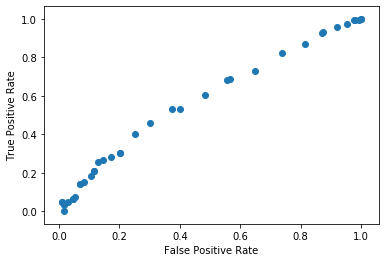

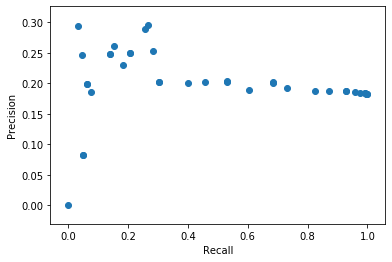

In [79]:
graph_precs = []
graph_recalls = []
graph_tprs = []
graph_fprs = []
for prob_threshold in metrics.keys():
    x = np.mean(metrics[prob_threshold], axis=0)
    print('Metrics with threshold {0:.2f}: Precision = {1:.2f} | Recall = {2:.2f} | TPR = {3:.2f} | FPR = {4:.2f}'.format(prob_threshold, x[0], x[1], x[2], x[3]))

    graph_precs.append(x[0])
    graph_recalls.append(x[1])
    graph_tprs.append(x[2])
    graph_fprs.append(x[3])
    
plt.scatter(graph_fprs, graph_tprs)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

plt.scatter(graph_recalls, graph_precs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()